<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP2 - Federico Iza</h4>
</div>

In [201]:
import pandas as pd
from tp1_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

In [202]:
%matplotlib inline
config_plots()

# Radar Signal Classification

## Data Acquisition

In [203]:
df = pd.read_csv('../data/ionosphere.data', header=None)

In [204]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [205]:
df.shape

(351, 35)

In [206]:
col_names = []
for i in range(1, N_SIGNALS+1):
    for suffix in ['R', 'I']:
        col_names.append(f'F{str(i)}{suffix}')
col_names.append('Target')

df.columns = col_names

In [207]:
df.describe()

,F1R,F1I,F2R,F2I,F3R,F3I,F4R,F4I,F5R,F5I,...,F13R,F13I,F14R,F14I,F15R,F15I,F16R,F16I,F17R,F17I
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Pre-processing

In [208]:
# Numerical data has to be used in ANNs
category_target = {'g': 1, 'b': 0}
df['Target'] = df['Target'].map(category_target)

In [209]:
df.describe()

,F1R,F1I,F2R,F2I,F3R,F3I,F4R,F4I,F5R,F5I,...,F13I,F14R,F14I,F15R,F15I,F16R,F16I,F17R,F17I,Target
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480,0.641026
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337,0.480384
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350,0.000000
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000,1.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Engineering

### Data Balance

In [210]:
data_balace = df['Target'].value_counts()
print(data_balace)

1    225
0    126
Name: Target, dtype: int64


In [211]:
# Remove data to balance dataset
counter = 99  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Target'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [212]:
df_aux.shape

(252, 35)

In [213]:
df_aux.describe()

,F1R,F1I,F2R,F2I,F3R,F3I,F4R,F4I,F5R,F5I,...,F13I,F14R,F14I,F15R,F15I,F16R,F16I,F17R,F17I,Target
count,252.000000,252.0,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.849206,0.0,0.547110,0.043779,0.505460,0.107812,0.460892,0.123959,0.434674,0.191342,...,-0.072956,0.532347,-0.077643,0.317007,-0.020509,0.292685,0.006653,0.307230,0.031325,0.500000
std,0.358560,0.0,0.545866,0.498093,0.572123,0.507206,0.525558,0.563613,0.521569,0.522277,...,0.525307,0.547773,0.584348,0.613260,0.512265,0.610047,0.518952,0.543401,0.459275,0.500995
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.0,0.289070,-0.076235,0.000000,-0.010778,0.000000,-0.026720,0.000000,-0.031148,...,-0.308335,0.245770,-0.511297,0.000000,-0.200930,0.000000,-0.174875,0.000000,-0.086727,0.000000
50%,1.000000,0.0,0.778920,0.010985,0.728050,0.014845,0.605965,0.008600,0.596505,0.016600,...,-0.010385,0.725540,-0.013560,0.426950,0.000000,0.367550,0.000000,0.305045,0.000000,0.500000
75%,1.000000,0.0,0.946620,0.280878,0.974190,0.361853,0.901598,0.559435,0.886880,0.641035,...,0.154175,1.000000,0.149095,0.896197,0.105483,0.864380,0.184830,0.810752,0.137678,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [214]:
data_balace = df_aux['Target'].value_counts()
print(data_balace)

0.0    126
1.0    126
Name: Target, dtype: int64


## Data Preparation

In [215]:
features = df_aux.loc[:, df_aux.columns != 'Target']
target =  df_aux.loc[:, df_aux.columns == 'Target']

## Modeling

In [216]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

In [217]:
input_size = feats_train.shape[1]  # Number of feat for training

In [218]:
# ANN architecture
model = Sequential()  # Instance the model

for i in range(N_LAYERS['radar']):  # Add layers
    model.add(Dense(units=N_NEURONS['radar'][i],  # Specify number of neurons
                    input_dim=input_size))  # Specify input size
    model.add(Activation(ACTIVATION_FUNCTIONS['radar'][i]))  # Add activation funcs

# Complile model
model.compile(loss=LOSS_FUNCTION,  # Select loss function
              optimizer=OPTIMIZER,  # Select optimizer
              metrics=[tf.keras.metrics.Accuracy()],  # Select metrics
              )

In [219]:
history = model.fit(feats_train, target_train,
                    epochs=N_EPOCHS['radar'],
                    validation_split=VALIDATION_SPLIT,
                    verbose=0)

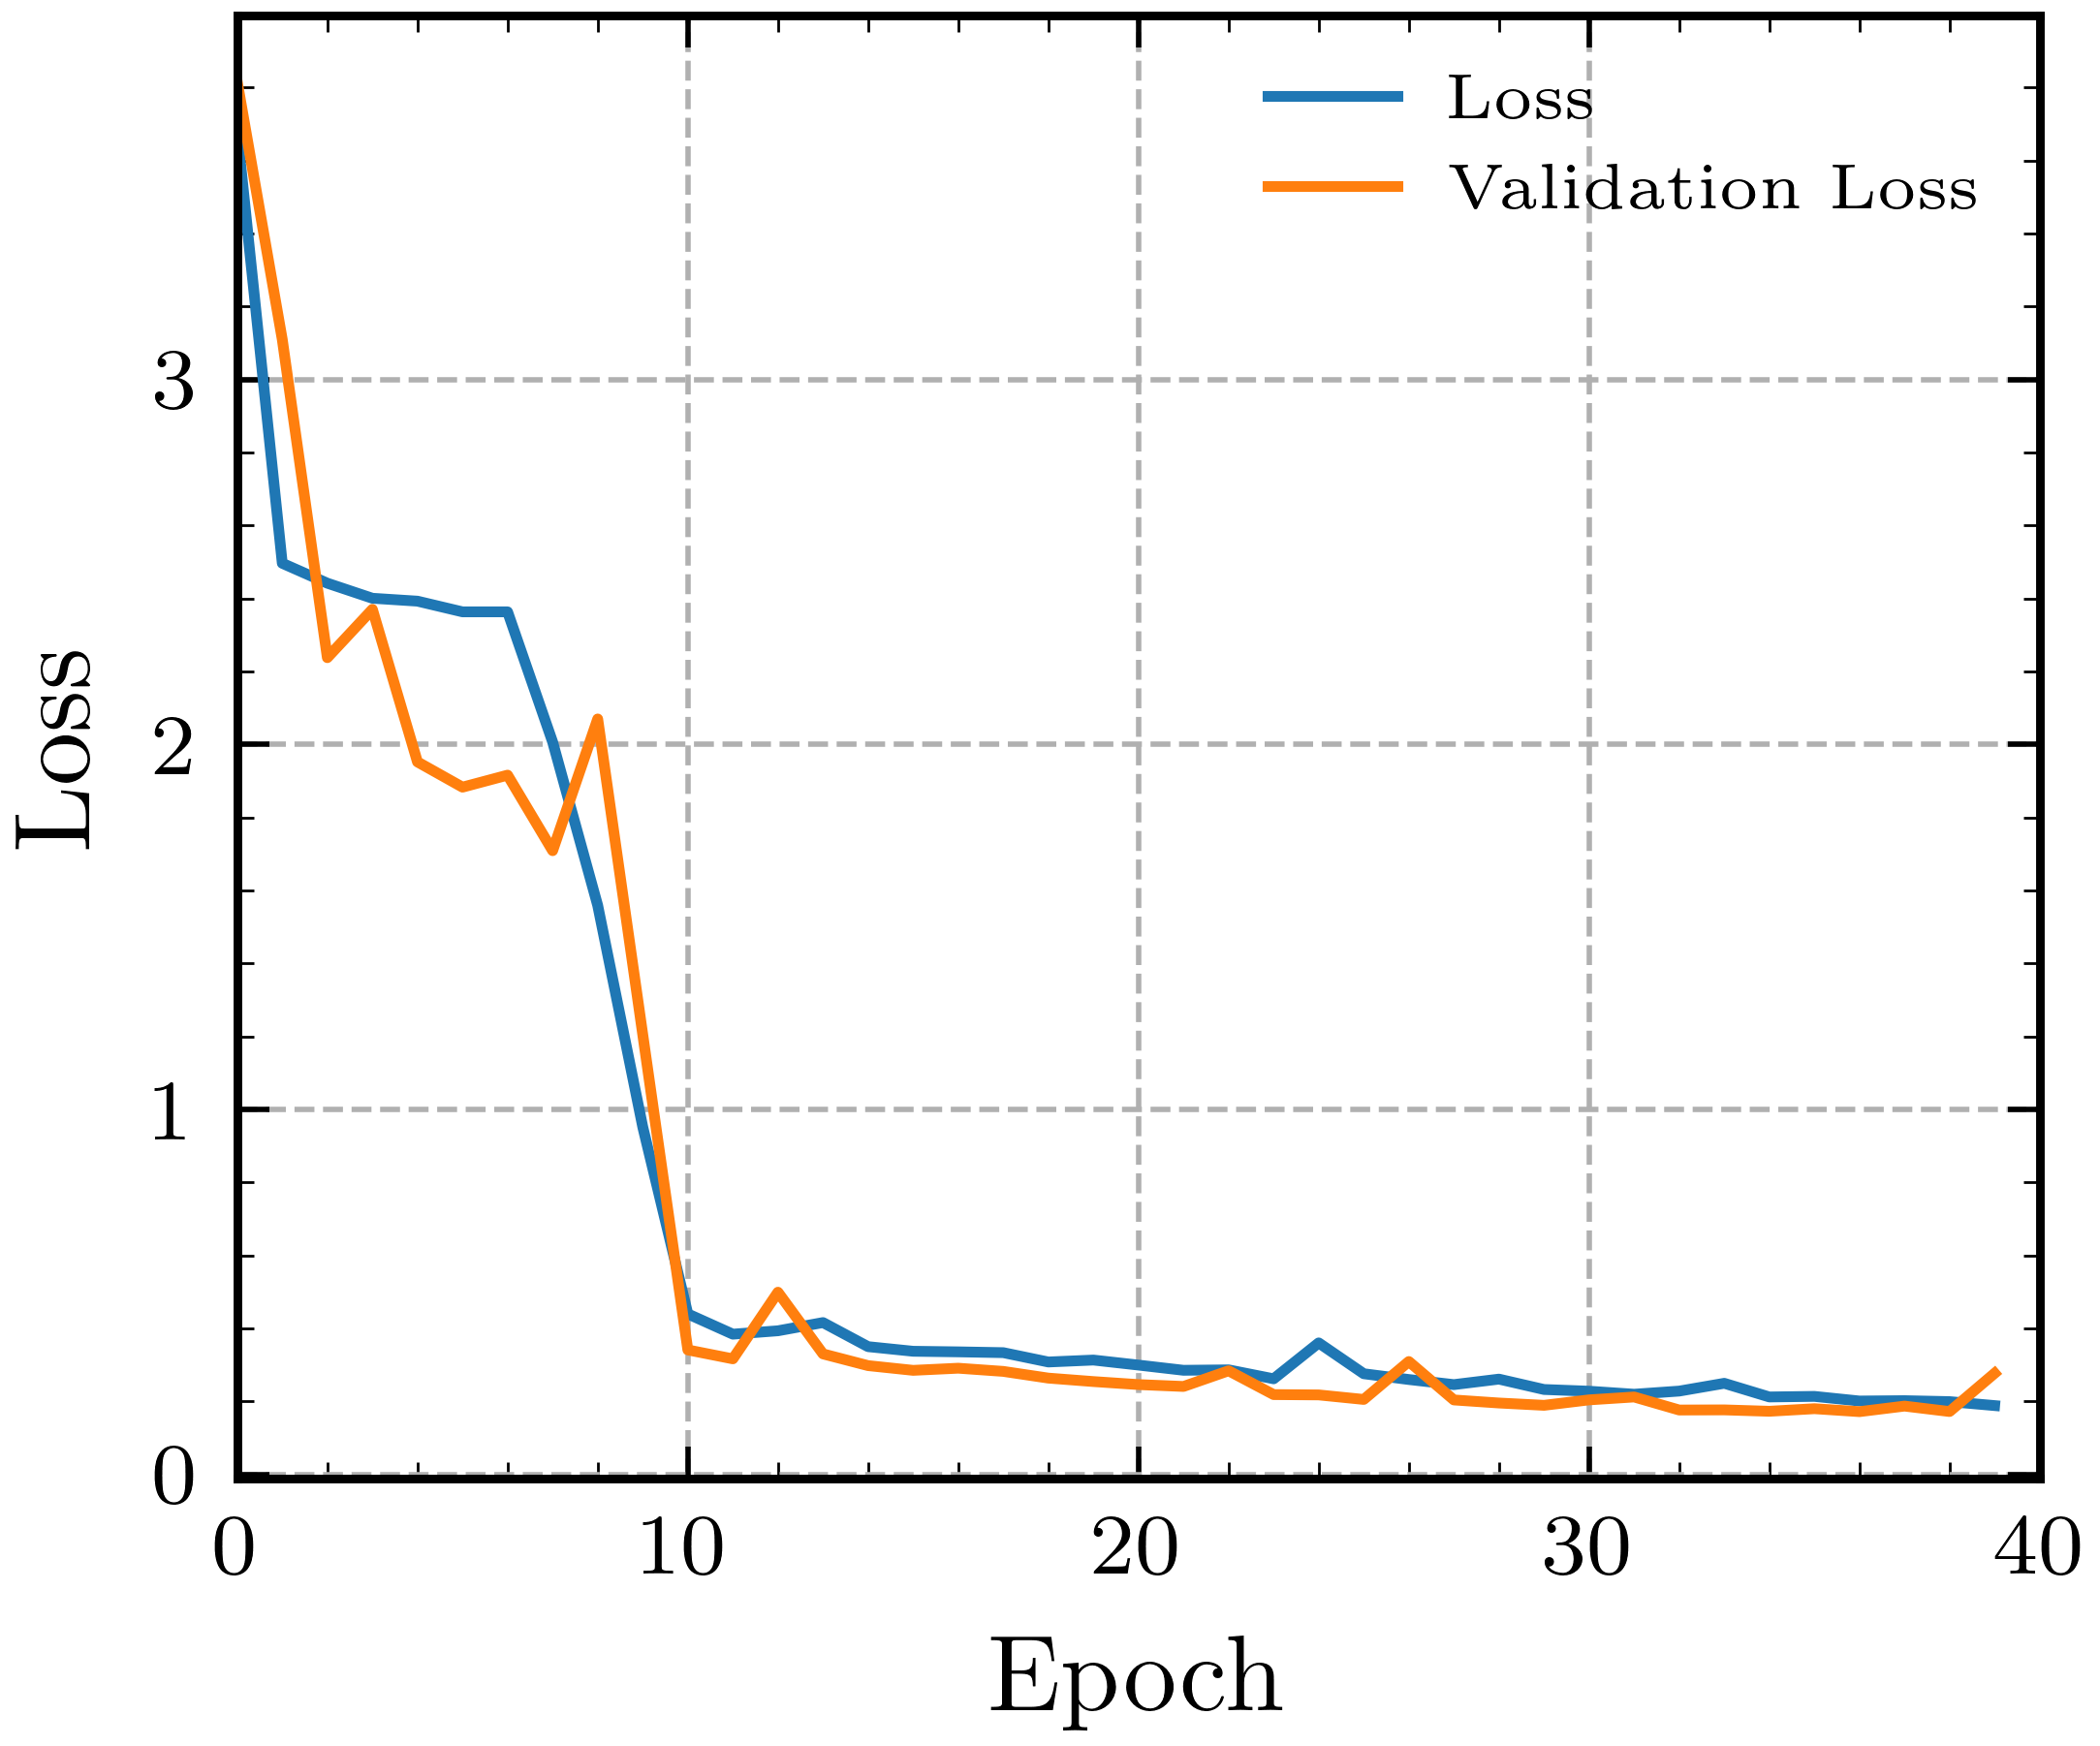

In [220]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(0, N_EPOCHS['radar'])
# ax.set_ylim(0, 5)

ax.plot(history.history['loss'], color='tab:blue',
        ls='-', lw=1, label='Loss')
ax.plot(history.history['val_loss'], color='tab:orange',
        ls='-',  lw=1, label='Validation Loss')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig1.pdf')
plt.show()

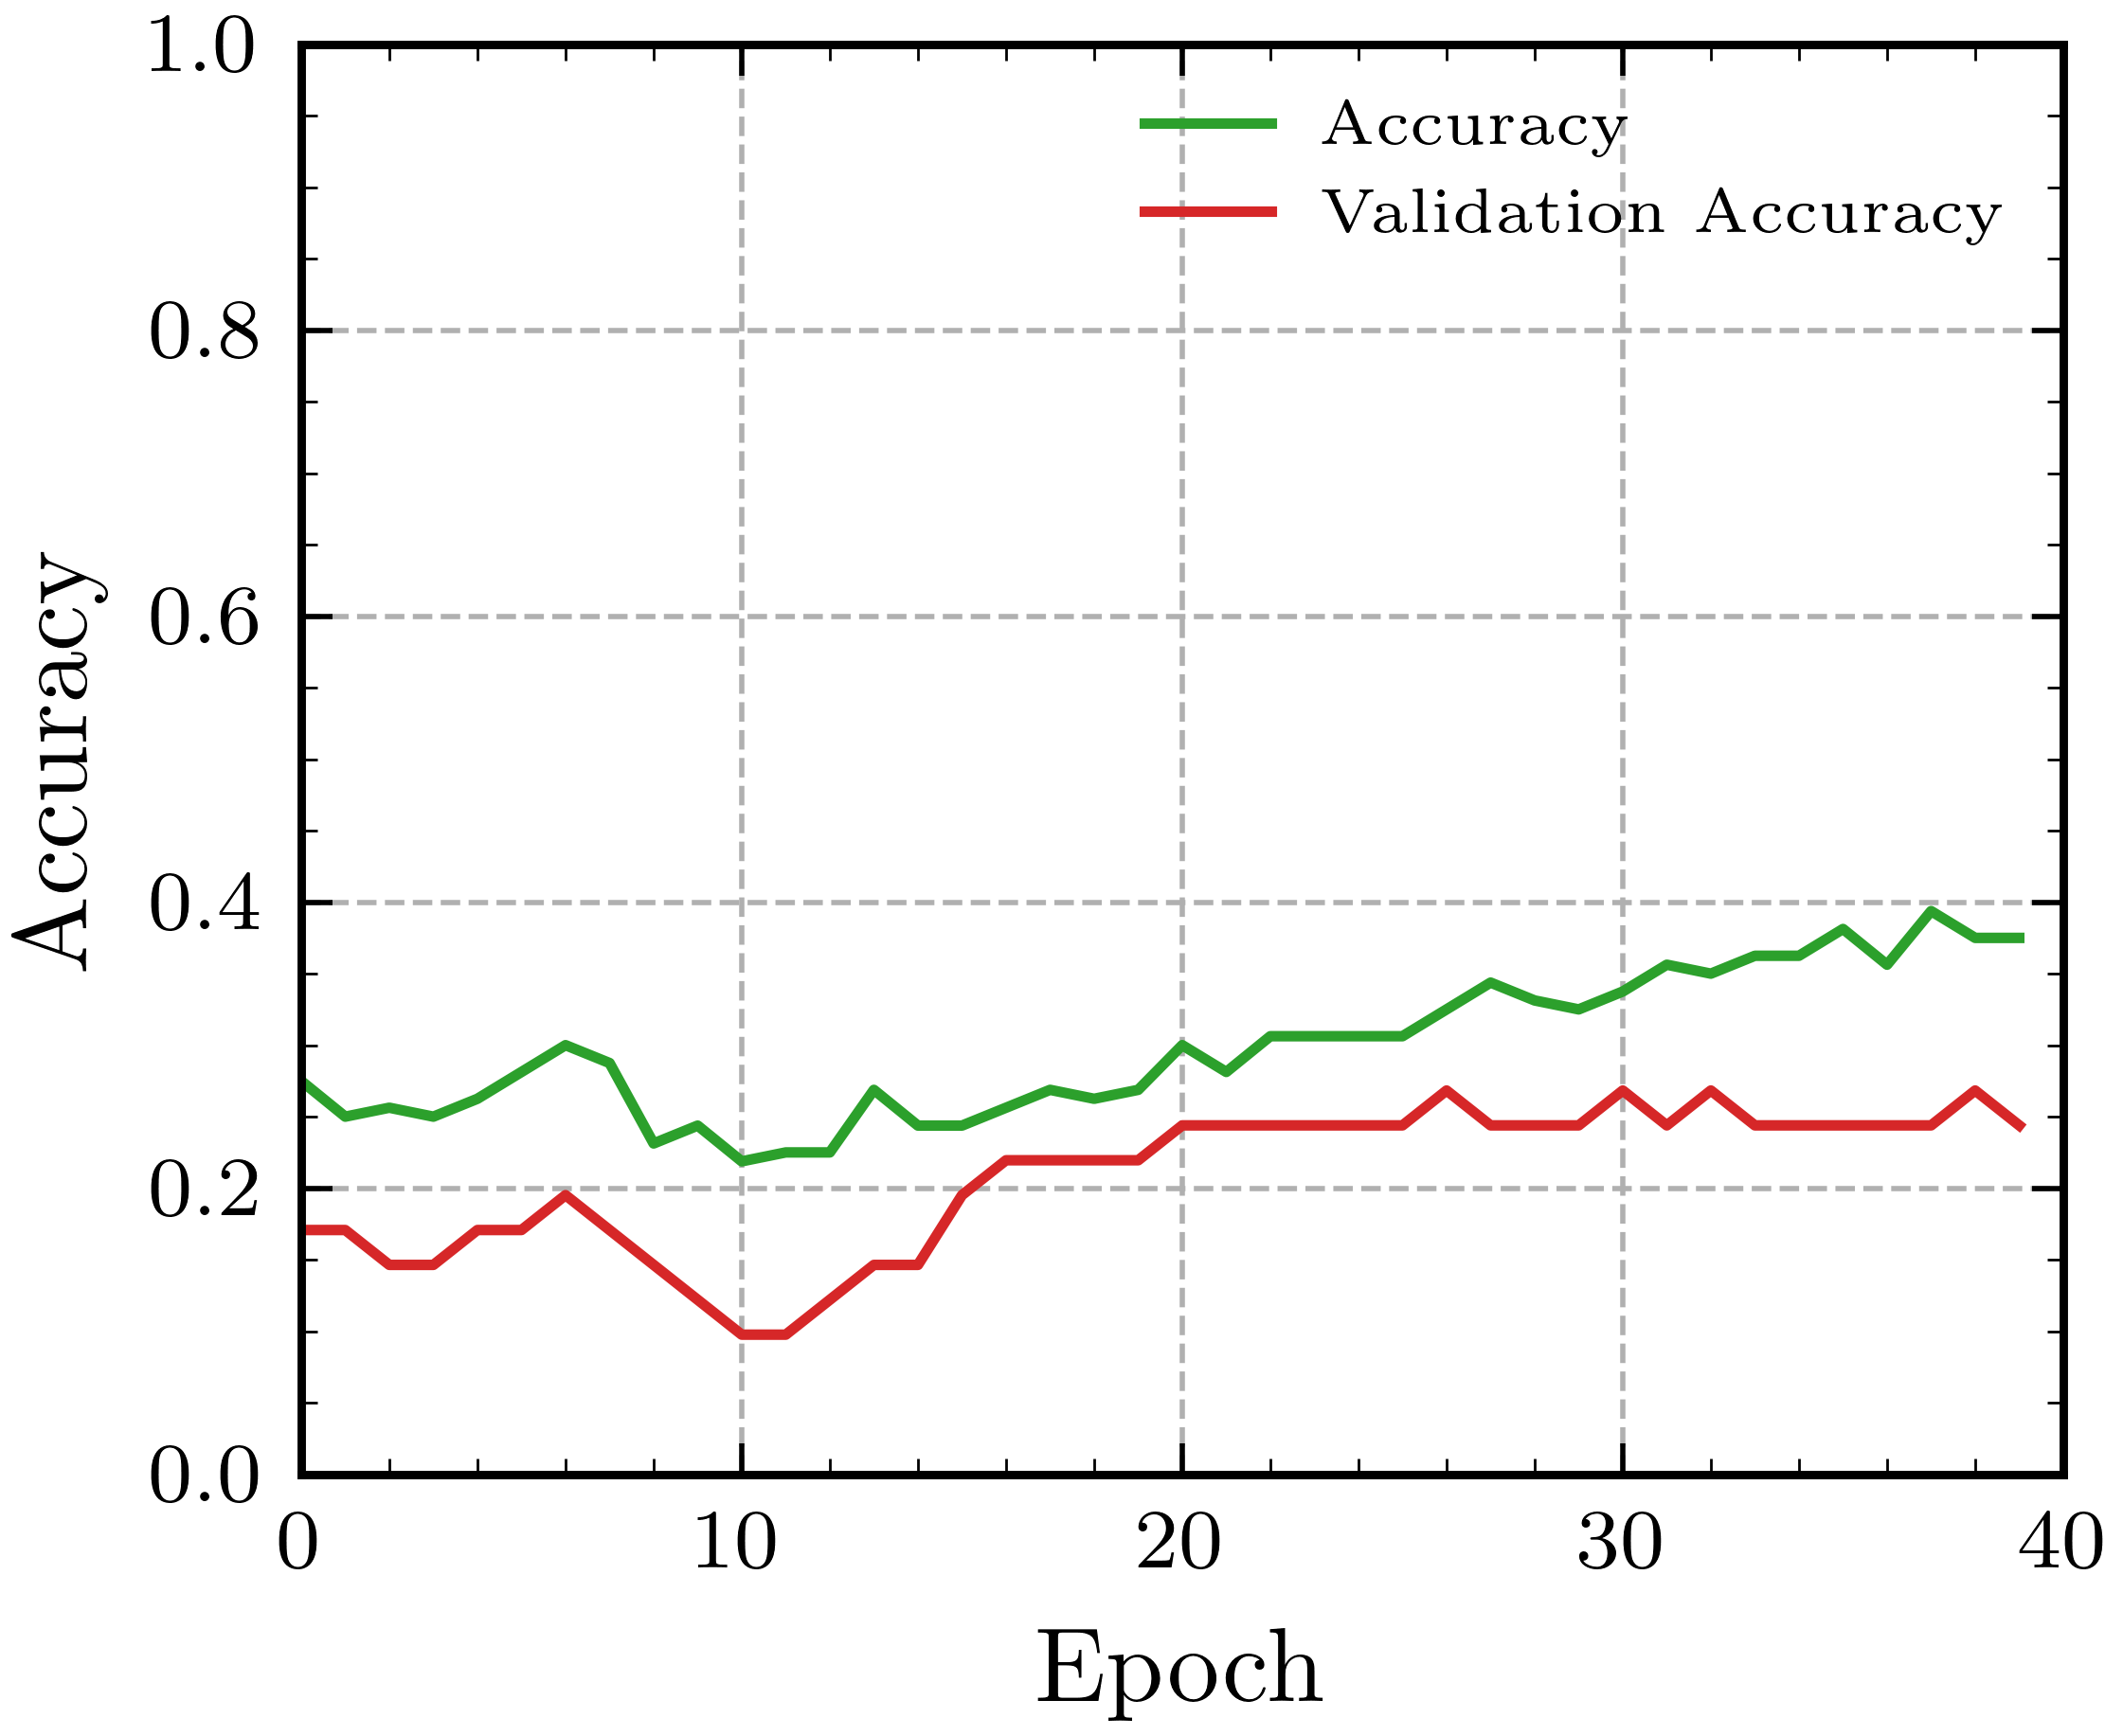

In [221]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(0, N_EPOCHS['radar'])
ax.set_ylim(0, 1)

ax.plot(history.history['accuracy'], color='tab:green',
        ls='-', lw=1, label='Accuracy')
ax.plot(history.history['val_accuracy'], color='tab:red',
        ls='-', lw=1, label='Validation Accuracy')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig2.pdf')
plt.show()

## Classification and Validation

In [222]:
y_pred = model.predict(feats_test)

2/2 [==============================] - 0s 3ms/step


In [223]:
cm = confusion_matrix(np.round(y_pred),
                      target_test,
                      labels=[0., 1.])

In [224]:
# Confusion matrix structure
# TN | FP
# FN | TP

print(cm)

[[18  1]
 [ 5 21]]


In [225]:
# print(np.diag(cm).sum() / cm.sum())
print(accuracy_score(target_test, np.round(y_pred)))

0.7647058823529411


# CMEs Classification

## Data Acquisition

In [226]:
df = pd.read_csv('../data/CMEs.csv')
df.rename(columns={'vprop': 'Velocity'}, inplace=True)

In [227]:
df.describe()

,Velocity
count,65.000000
mean,718.676923
std,402.923849
min,232.000000
25%,409.000000
50%,592.000000
75%,937.000000
max,1968.000000


## Data Pre-processing

In [228]:
# Numerical data has to be used in ANNs
numerical_origin = {'flare': 1, 'no flare': 0}
df['Origin'] = df['Origin'].map(numerical_origin)

numerical_activity = {'low': 0, 'high': 1}
df['SunActivity'] = df['SunActivity'].map(numerical_activity)

In [229]:
df.describe()

,SunActivity,Velocity,Origin
count,65.000000,65.000000,65.00000
mean,0.661538,718.676923,0.60000
std,0.476869,402.923849,0.49371
min,0.000000,232.000000,0.00000
25%,0.000000,409.000000,0.00000
50%,1.000000,592.000000,1.00000
75%,1.000000,937.000000,1.00000
max,1.000000,1968.000000,1.00000


In [230]:
np.sum(df == np.nan)

SunActivity    0
Velocity       0
Origin         0
dtype: int64

## Feature Engineering

### Data Balance

In [231]:
data_balace = df['Origin'].value_counts()
print(data_balace)

1    39
0    26
Name: Origin, dtype: int64


In [232]:
# Remove data to balance dataset
counter = 13  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Origin'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [233]:
data_balace = df_aux['Origin'].value_counts()
print(data_balace)

1    26
0    26
Name: Origin, dtype: int64


In [234]:
df_aux.describe()

,SunActivity,Velocity,Origin
count,52.000000,52.000000,52.000000
mean,0.653846,697.346154,0.500000
std,0.480384,395.119485,0.504878
min,0.000000,232.000000,0.000000
25%,0.000000,408.500000,0.000000
50%,1.000000,551.500000,0.500000
75%,1.000000,880.750000,1.000000
max,1.000000,1968.000000,1.000000


## Data Preparation

In [235]:
features = df_aux.loc[:, df_aux.columns != 'Origin'].copy()
target =  df_aux.loc[:, df_aux.columns == 'Origin'].copy()

In [236]:
features

,SunActivity,Velocity
0,0,1968
1,0,1173
2,0,1600
3,0,1089
4,0,453
5,1,1152
6,1,790
7,1,937
8,1,552
9,1,963


In [237]:
# Scaling analysis (if necessary)
print(features.min(), features.max())

SunActivity      0
Velocity       232
dtype: int64 SunActivity       1
Velocity       1968
dtype: int64


In [238]:
scaler = MinMaxScaler()
features.loc[:, 'Velocity'] = scaler.fit_transform(
    np.array(features['Velocity']).reshape(-1, 1))

In [239]:
features

,SunActivity,Velocity
0,0,1.000000
1,0,0.542051
2,0,0.788018
3,0,0.493664
4,0,0.127304
5,1,0.529954
6,1,0.321429
7,1,0.406106
8,1,0.184332
9,1,0.421083


In [240]:
# Scaling analysis (if necessary)
print(features.min(), features.max())

SunActivity    0.0
Velocity       0.0
dtype: float64 SunActivity    1.0
Velocity       1.0
dtype: float64


## Modeling

In [241]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

In [242]:
input_size = feats_train.shape[1]  # Number of feat for training
print(input_size)

2


In [243]:
# ANN architecture
model = Sequential()  # Instance the model

for i in range(N_LAYERS['cems']):  # Add layers
    model.add(Dense(units=N_NEURONS['cems'][i],  # Specify number of neurons
                    input_dim=input_size))  # Specify input size
    model.add(Activation(ACTIVATION_FUNCTIONS['cems'][i]))  # Add activation funcs

# Complile model
model.compile(loss=LOSS_FUNCTION,  # Select loss function
              optimizer=OPTIMIZER,  # Select optimizer
              metrics=[tf.keras.metrics.Accuracy()],  # Select metrics
              )

In [244]:
history = model.fit(feats_train, target_train,
                    epochs=N_EPOCHS['cems'],
                    validation_split=VALIDATION_SPLIT,
                    verbose=0)

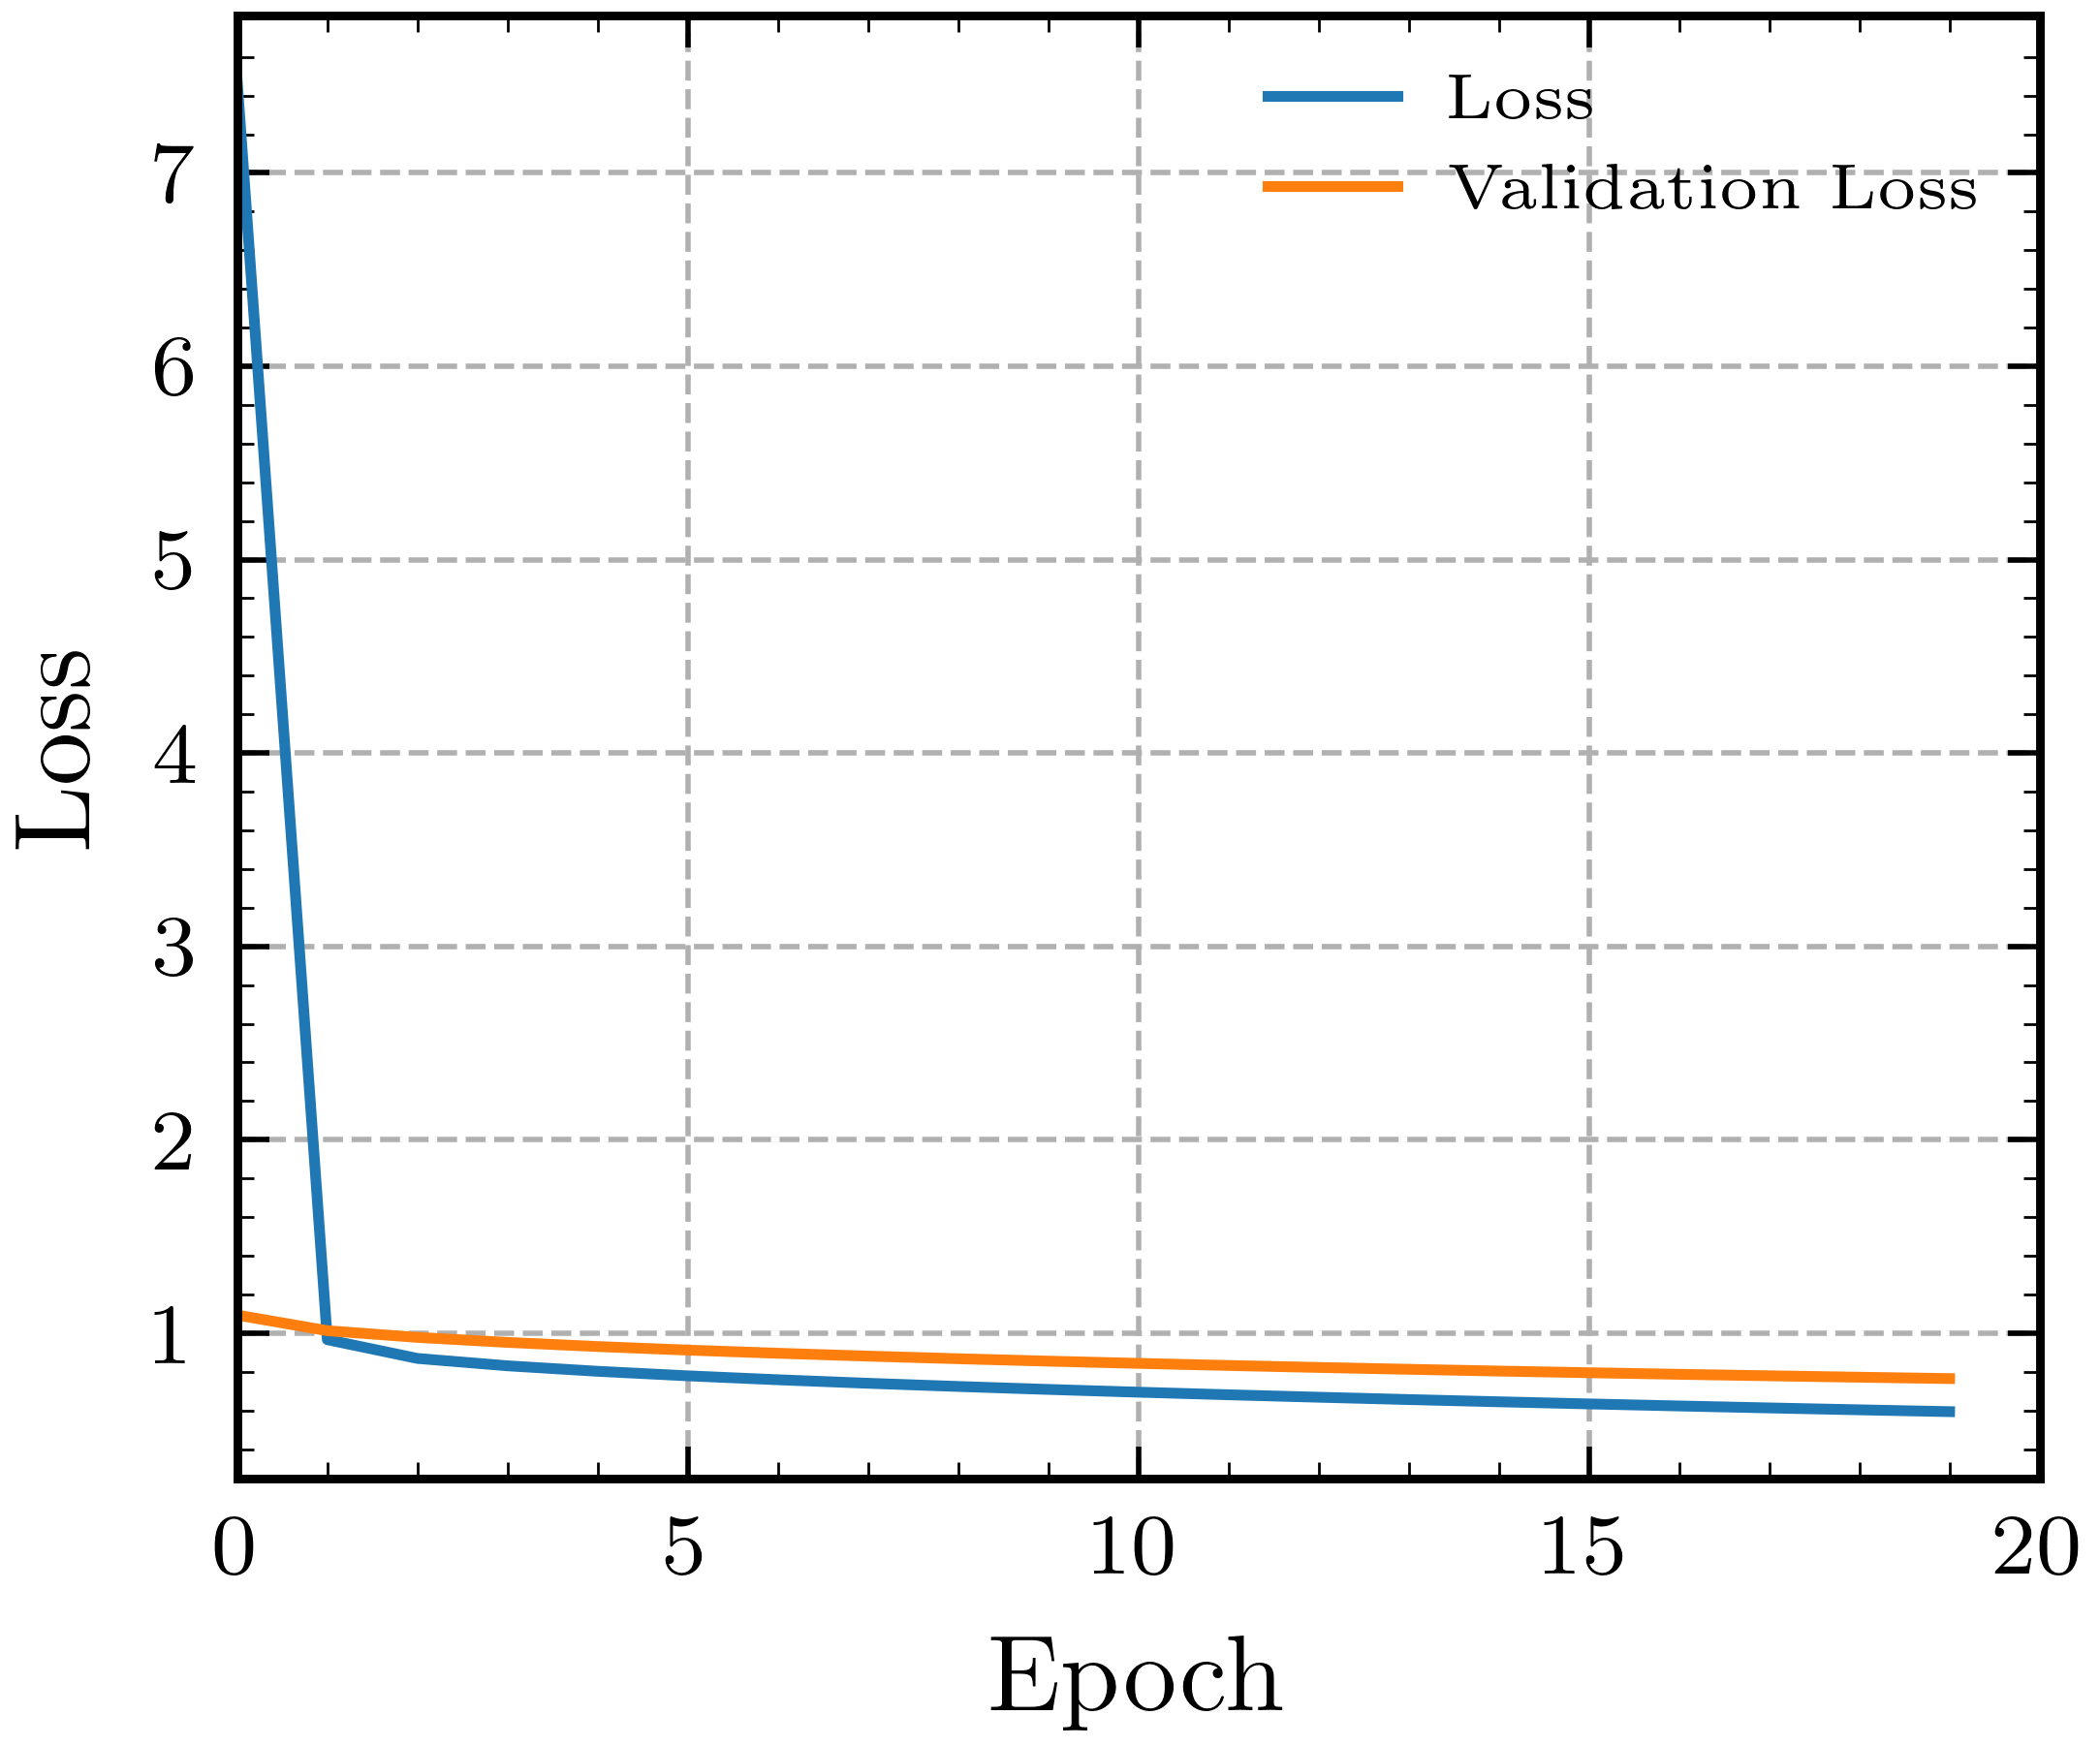

In [245]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(0, N_EPOCHS['cems'])
# ax.set_ylim(0, 5)

ax.plot(history.history['loss'], color='tab:blue',
        ls='-', lw=1, label='Loss')
ax.plot(history.history['val_loss'], color='tab:orange',
        ls='-',  lw=1, label='Validation Loss')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig3.pdf')
plt.show()

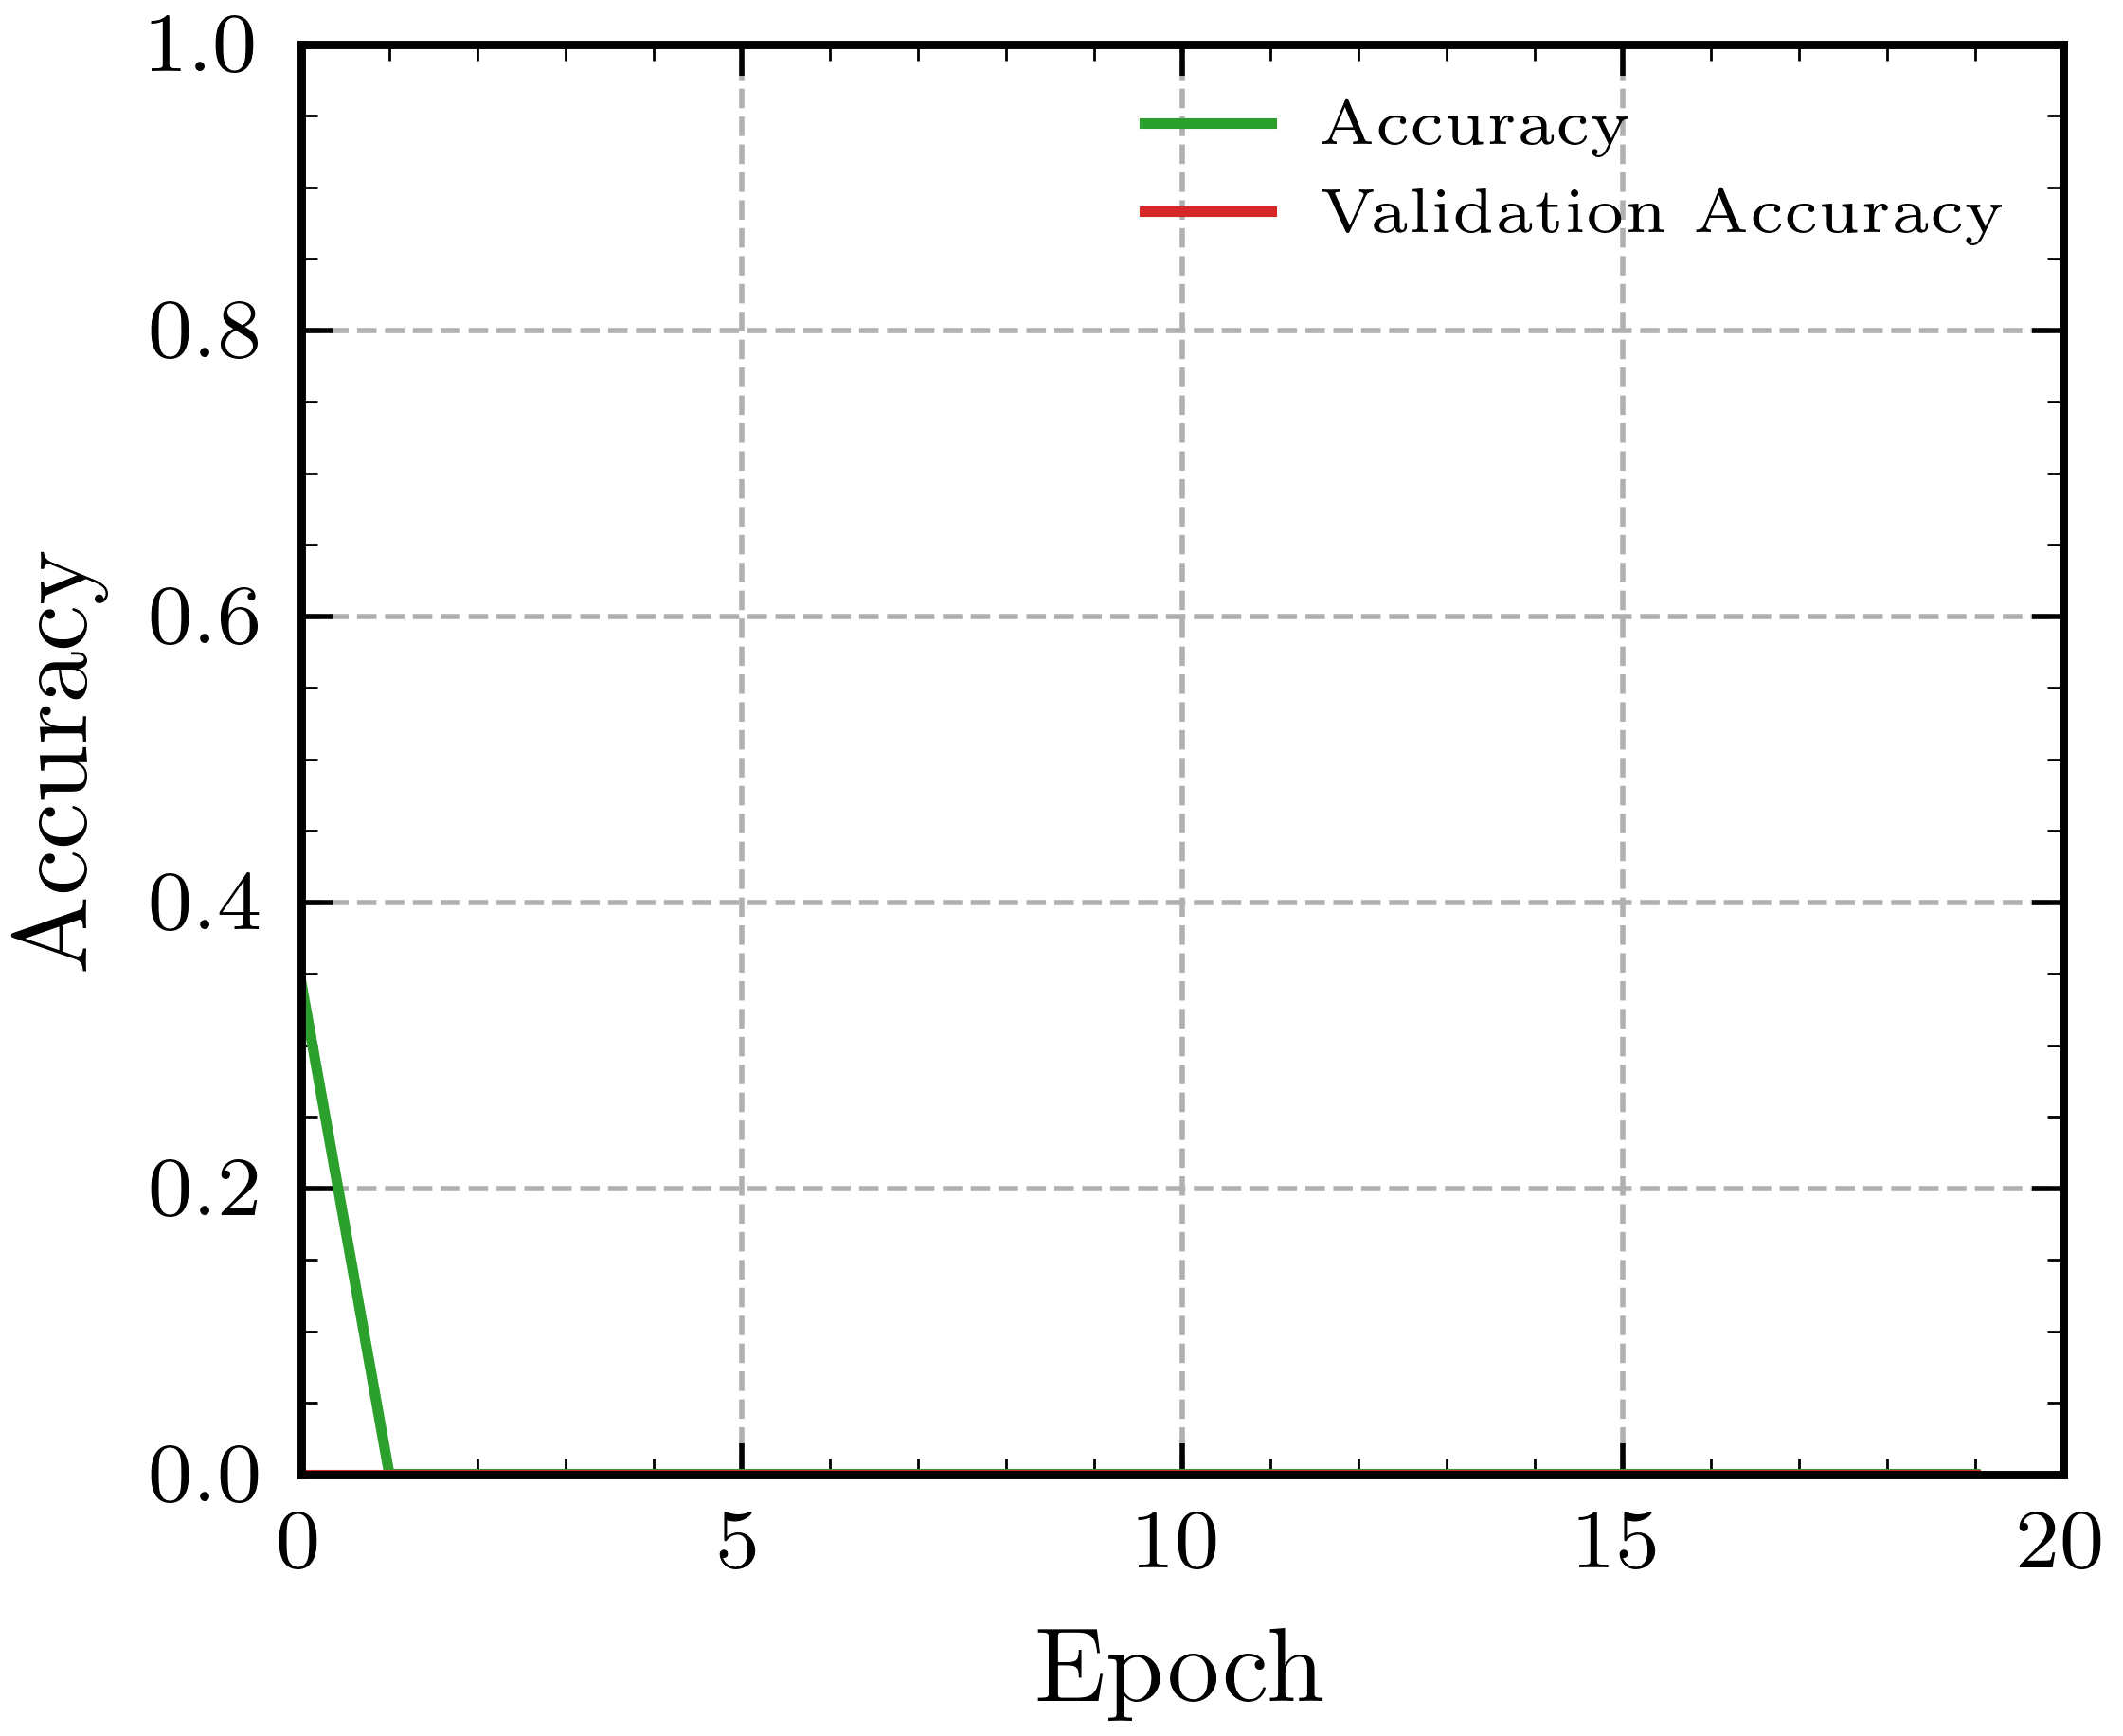

In [246]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(0, N_EPOCHS['cems'])
ax.set_ylim(0, 1)

ax.plot(history.history['accuracy'], color='tab:green',
        ls='-', lw=1, label='Accuracy')
ax.plot(history.history['val_accuracy'], color='tab:red',
        ls='-', lw=1, label='Validation Accuracy')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig4.pdf')
plt.show()

## Classification and Validation

In [247]:
y_pred = model.predict(feats_test)

1/1 [==============================] - 0s 43ms/step


In [248]:
cm = confusion_matrix(np.round(y_pred),
                      target_test,
                      labels=[0., 1.])

In [249]:
# Confusion matrix structure
# TN | FP
# FN | TP

print(cm)

[[5 4]
 [0 2]]


In [250]:
# print(np.diag(cm).sum() / cm.sum())
print(accuracy_score(target_test, np.round(y_pred)))

0.6363636363636364
